<a href="https://colab.research.google.com/github/udayameister/Multimodel_GNN/blob/main/ROC_Curve_Multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ROC Curve - Multiclass
Vinicius Trevisan - 2022

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

## Functions
Slightly modified from the binary classifier case

In [ ]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations

    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes

    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''

    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]

    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate

    return tpr, fpr

In [ ]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.

    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.

    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [ ]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).

    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()

    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

## Multiclass classification evaluation with KS test

### Creating a synthetic dataset

In [ ]:
scale = 3.5
size = 500

In [ ]:
class1_x = np.random.normal(loc = 10, scale = scale, size = size)
class1_y = np.random.normal(loc = 1, scale = scale, size = size)

In [ ]:
class2_x = np.random.normal(loc = 1, scale = scale, size = size)
class2_y = np.random.normal(loc = 5, scale = scale, size = size)

In [ ]:
class3_x = np.random.normal(loc = 10, scale = scale, size = size)
class3_y = np.random.normal(loc = 10, scale = scale, size = size)

In [ ]:
class4_x = np.random.normal(loc = 5, scale = scale, size = size)
class4_y = np.random.normal(loc = 10, scale = scale, size = size)

In [ ]:
df_class1 = pd.DataFrame({'x' : class1_x, 'y' : class1_y, 'class': 'CN'})
df_class2 = pd.DataFrame({'x' : class2_x, 'y' : class2_y, 'class': 'EMCI'})
df_class3 = pd.DataFrame({'x' : class3_x, 'y' : class3_y, 'class': 'LMCI'})
df_class4 = pd.DataFrame({'x' : class4_x, 'y' : class3_y, 'class': 'AD'})
# Use pd.concat instead of append
df = pd.concat([df_class1, df_class2], ignore_index=True)
df = pd.concat([df, df_class3], ignore_index=True)
# To include df_class4 as well:
df = pd.concat([df, df_class4], ignore_index=True)

<Axes: xlabel='x', ylabel='y'>

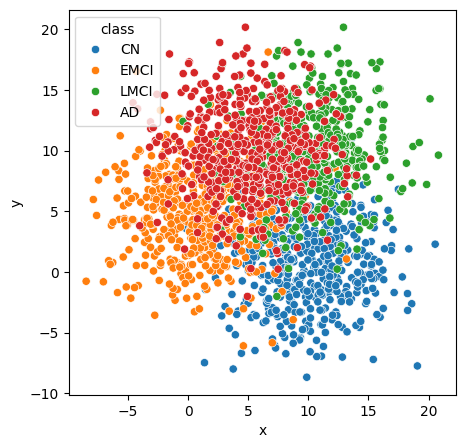

In [ ]:
# Plot them to show how much they intersect
plt.figure(figsize=(5, 5))
sns.scatterplot(x = 'x', y = 'y', hue = 'class', data = df)

In [ ]:
X = df[['x', 'y']]
y = df['class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### Fits the model and make the predictions

In [ ]:
model_multiclass = RandomForestClassifier(n_estimators = 50, criterion = 'gini')

In [ ]:
model_multiclass.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50)

In [ ]:
y_pred = model_multiclass.predict(X_test)

In [ ]:
y_proba = model_multiclass.predict_proba(X_test)

## ROC Curve - One vs Rest (OvR)
Compares each class with the rest of the classes

In [ ]:
classes = model_multiclass.classes_
classes

array(['AD', 'CN', 'EMCI', 'LMCI'], dtype=object)

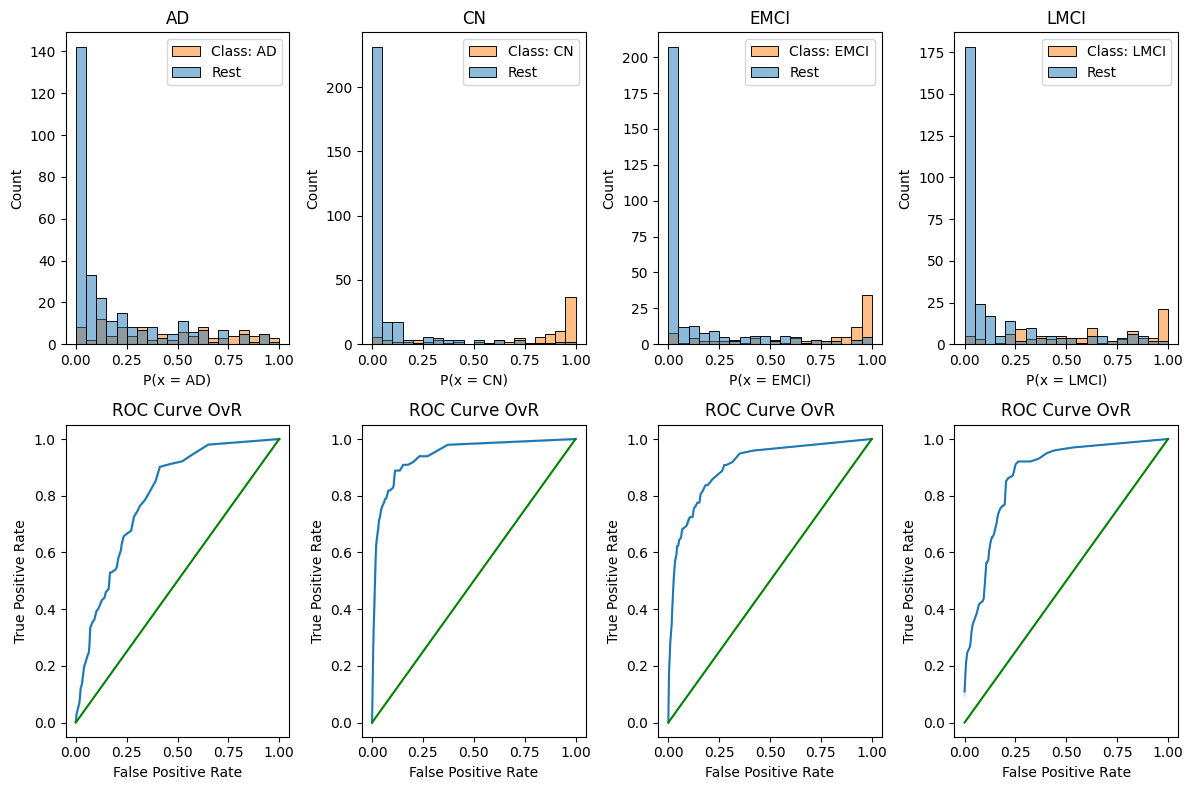

In [ ]:
# Plots the Probability Distributions and the ROC Curves One vs Rest
plt.figure(figsize = (12, 8))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovr = {}

for i in range(len(classes)):
    # Gets the class
    c = classes[i]

    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = [1 if y == c else 0 for y in y_test]
    df_aux['prob'] = y_proba[:, i]
    df_aux = df_aux.reset_index(drop = True)

    # Plots the probability distribution for the class and the rest
    # Changed subplot index calculation to i + 1
    ax = plt.subplot(2, 4, i + 1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(c)
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")

    # Calculates the ROC Coordinates and plots the ROC Curves
    # Corrected the index calculation to ensure it stays within the 2x3 grid (1 to 6)
    ax_bottom = plt.subplot(2, 4, i + 5)  # Corrected index calculation: i + 3 + 1 to i+3
                                                                       # previously it was trying to access subplot with index 7 ( 2+4+1)
                                                                       # in 2X3 (2 rows and 3 columns) subplot grid but only index from 1 to 6 are valid.
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvR")

    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])

plt.tight_layout()

In [ ]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovr:
    avg_roc_auc += roc_auc_ovr[k]
    i += 1
    print(f"{k} ROC AUC OvR: {roc_auc_ovr[k]:.4f}")
print(f"average ROC AUC OvR: {avg_roc_auc/i:.4f}")

AD ROC AUC OvR: 0.7940
CN ROC AUC OvR: 0.9435
EMCI ROC AUC OvR: 0.9039
LMCI ROC AUC OvR: 0.8724
average ROC AUC OvR: 0.8784


In [ ]:
# Compares with sklearn (average only)
# "Macro" average = unweighted mean
roc_auc_score(y_test, y_proba, labels = classes, multi_class = 'ovr', average = 'macro')

0.8784479488778972

## ROC Curve - One vs One (OvO)
Compares each possible combination of the classes, two at a time

In [ ]:
classes_combinations = []
class_list = list(classes)
for i in range(len(class_list)):
    for j in range(i+1, len(class_list)):
        classes_combinations.append([class_list[i], class_list[j]])
        classes_combinations.append([class_list[j], class_list[i]])
classes_combinations

[['AD', 'CN'],
 ['CN', 'AD'],
 ['AD', 'EMCI'],
 ['EMCI', 'AD'],
 ['AD', 'LMCI'],
 ['LMCI', 'AD'],
 ['CN', 'EMCI'],
 ['EMCI', 'CN'],
 ['CN', 'LMCI'],
 ['LMCI', 'CN'],
 ['EMCI', 'LMCI'],
 ['LMCI', 'EMCI']]

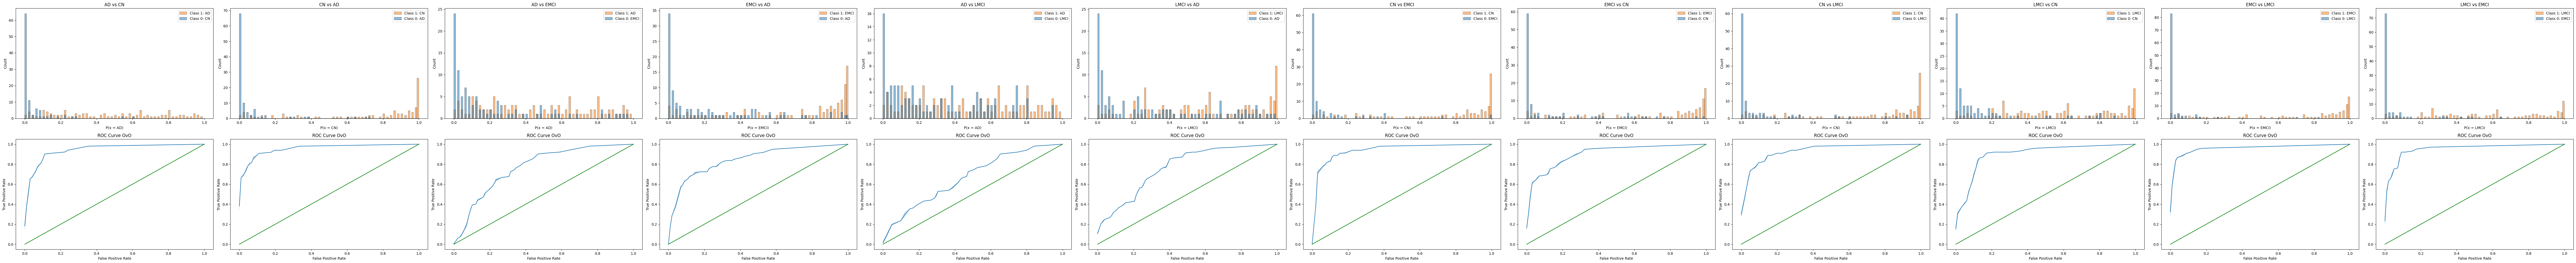

In [ ]:
# Plots the Probability Distributions and the ROC Curves One vs ONe
plt.figure(figsize = (10, 1))
bins = [i/10 for i in range(10)] + [1]
roc_auc_ovo = {}

for i in range(len(classes_combinations)):
    # Gets the class
    comb = classes_combinations[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = class_list.index(c1)
    title = c1 + " vs " +c2

    # Prepares an auxiliar dataframe to help with the plots
    df_aux = X_test.copy()
    df_aux['class'] = y_test
    df_aux['prob'] = y_proba[:, c1_index]

    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop = True)

    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(4, 12, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(title)
    ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
    ax.set_xlabel(f"P(x = {c1})")

    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(4, 12, i+13)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvO")

    # Calculates the ROC AUC OvO
    roc_auc_ovo[title] = roc_auc_score(df_aux['class'], df_aux['prob'])

plt.tight_layout()

In [ ]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovo:
    avg_roc_auc += roc_auc_ovo[k]
    i += 1
    print(f"{k} ROC AUC OvO: {roc_auc_ovo[k]:.4f}")
print(f"average ROC AUC OvO: {avg_roc_auc/i:.4f}")

AD vs CN ROC AUC OvO: 0.9433
CN vs AD ROC AUC OvO: 0.9565
AD vs EMCI ROC AUC OvO: 0.7704
EMCI vs AD ROC AUC OvO: 0.8468
AD vs LMCI ROC AUC OvO: 0.6707
LMCI vs AD ROC AUC OvO: 0.7665
CN vs EMCI ROC AUC OvO: 0.9391
EMCI vs CN ROC AUC OvO: 0.9047
CN vs LMCI ROC AUC OvO: 0.9345
LMCI vs CN ROC AUC OvO: 0.9025
EMCI vs LMCI ROC AUC OvO: 0.9607
LMCI vs EMCI ROC AUC OvO: 0.9522
average ROC AUC OvO: 0.8790


In [ ]:
# Compares with sklearn (average only)
# "Macro" average = unweighted mean
roc_auc_score(y_test, y_proba, labels = classes, multi_class = 'ovo', average = 'macro')

0.878997099639936